# CICY4: Training results of all models

In this notebook, we collect the training results of all models for further analyses. We have trained 12 models so far. The models can be broadly categorized into CNN-RNN hybrid architecture and LSTM-based architecture. 

- CNN-GRU hybrids :
    - CNN-GRU-384
    - CNN-GRU-416
    - ResNet-GRU-256
    - ResNet-GRU-400
- CNN-LSTM hybrids:  
    - CNN-LSTM-256
    - CNN-LSTM-384
    - CNN-LSTM-400
    - CNN-LSTM-416
- LSTM-based:
    - LSTM-400
    - LSTM-424
    - LSTM-448
    - LSTM-456
    
    The best performing model so far is CNN-LSTM-400, followed by LSTM-448 and LSTM-424. In this notebook, we also calculate the ensemble accuracy for the 2 or 3 best models. 

In [1]:
import numpy as np
import pandas as pd
import random
import os as os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
#sns.set_style("darkgrid")
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
seed = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

# Load data

In [4]:
X_train = np.load('/kaggle/input/cicy4-data-processing/conf_Xtrain.npy')
X_test = np.load('/kaggle/input/cicy4-data-processing/conf_Xtest.npy')
X_valid = np.load('/kaggle/input/cicy4-data-processing/conf_Xvalid.npy')

y_train = np.load('/kaggle/input/cicy4-data-processing/hodge_ytrain.npy')
y_test= np.load('/kaggle/input/cicy4-data-processing/hodge_ytest.npy')
y_valid = np.load('/kaggle/input/cicy4-data-processing/hodge_yvalid.npy')

#Convert data to torch tensor with float32 precision 
#(needed to be compatible with the floating decision of the network parameters)
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))

X_valid = torch.from_numpy(X_valid.astype(np.float32)) 
y_valid = torch.from_numpy(y_valid.astype(np.float32)) 

X_test = torch.from_numpy(X_test.astype(np.float32)) 
y_test= torch.from_numpy(y_test.astype(np.float32))

print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

torch.Size([652092, 16, 20]) torch.Size([72455, 16, 20]) torch.Size([181137, 16, 20])
torch.Size([652092, 4]) torch.Size([72455, 4]) torch.Size([181137, 4])


In [5]:
class CICY4Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y        
    def __len__(self):
        return len(self.X)      
    def __getitem__(self, idx):
        X0 = self.X[idx]
        y0 = self.y[idx]  
        return X0, y0
        
train_set = CICY4Dataset(X_train, y_train)
val_set = CICY4Dataset(X_valid, y_valid)
test_set = CICY4Dataset(X_test, y_test)

In [6]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

# Utility functions

In [7]:
################## GET PREDICTIONS + ACCURACY #####################
def get_pred_n_acc(models, device, dataloader, num_iter):
    i = 0
    ypreds =[]
    targets = []
    #The last batch might not have size 128
    while i< num_iter:
        for data, target in dataloader:
            #this empty list is to hold all models' preds
            ypred = []    
            data= data.to(device)
            data = data.to(torch.float32)
            target = target.to(torch.float32)
            #append the 'i^th' target
            targets.append(target)
            for model in models:
                model.eval()
                yp = model(data)
                yp = yp.detach().cpu().numpy()
                ypred.append(yp)
            #take the mean of all models' predictions
            ypred = np.array(ypred).mean(axis = 0)
            ypred = np.round(ypred)
            i+=1
            #append ypred, targets inside the 'i' loop
            # append the 'i^th' mean prediction
            ypreds.append(ypred)   
            if i == num_iter:
                break 
     #Do not convert ypreds, targets to np.array at this point,
    #since the last batch has a different size, causing an error !
    #CALCULATING ACCURACY    
    yp =  np.concatenate([ypreds[j] for j in range(len(ypreds))], axis = 0)
    tgs =  np.concatenate([targets[j] for j in range(len(targets))], axis = 0)
    h11_acc = ((yp[:,0] == tgs[:,0]).sum())/len(yp)
    h21_acc = ((yp[:,1] == tgs[:,1]).sum())/len(yp)
    h31_acc = ((yp[:,2] == tgs[:,2]).sum())/len(yp)
    h22_acc = ((yp[:,3] == tgs[:,3]).sum())/len(yp)
    acc = [h11_acc*100,h21_acc*100,h31_acc*100,h22_acc*100 ]
    return  yp, tgs, acc

In [8]:
def load_model_and_get_pred(load_model_weight, model_name):
    trained_model = torch.load(load_model_weight)  
    yt, tgt, acct = get_pred_n_acc([trained_model], device, train_loader, num_iter = len(train_loader))
    #validation accuracy
    yv, tgv, accv = get_pred_n_acc([trained_model], device, val_loader, num_iter = len(val_loader))
    print(f'\n Train accuracies for {model_name}: {acct} ')
    print(f'\n Validation accuracies for {model_name}: {accv}')
    #Test accuracy
    yts, tgts, accts = get_pred_n_acc([trained_model], device, test_loader, num_iter = len(test_loader))
    print(f'\n Test accuracies for {model_name}: {accts} \n')
    return trained_model, acct, accv, accts

# Network building blocks

In [9]:
# CNN BLOCK
class CNN_block(nn.Module):  
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,128, 4, 1)
        #self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 64, 3, 1)
        #self.bn2 = nn.BatchNorm2d(64)
        self.mxpool = nn.MaxPool2d(2,2)
        #self.conv3 = nn.Conv2d(128,64, 2, 1)
        self.flat = nn.Flatten()
        self.conv_total = nn.Sequential(
            self.conv1,
            self.mxpool,
            self.conv2,
            self.mxpool
        )
    def forward(self,x):
        x = F.relu(self.conv_total(x))
        #reshape is the same as flat(x)
        #x = x.reshape(x.shape[0], -1)
        x = self.flat(x)   
        return x

In [10]:
#RESNET BLOCK
# CNN ###############################
class ResNet_block(nn.Module):    
    def __init__(self, filters, kernels):
        super().__init__()
        f1, f2, f3 = filters
        k1, k2, k3 = kernels
        self.conv1 = nn.Conv2d(1,f1, k1, 1)
        self.conv2 = nn.Conv2d(f1,f2, k2, 1)
        self.conv3 = nn.Conv2d(f2,f3, k3, 1)
        self.maxpool = nn.MaxPool2d(2,2)
        self.flat = nn.Flatten()
        self.relu = nn.ReLU()
        #this layer is to get the identity to have
        #the same shape as the other branch, bias = False
        self.fc0 = nn.Linear(320,256, bias = False)
        #convolution branch/main branch
        self.conv_total = nn.Sequential(
            self.conv1,
            self.maxpool,
            self.relu,
            self.conv2,
            self.maxpool,
            self.relu,
            self.conv3,
            self.flat
        )
        #shortcut branch
        self.shortcut = nn.Sequential(self.flat, self.fc0)

    def forward(self,x):
        #x_i and x must have the same shape
        x_i = self.shortcut(x)
        x = self.conv_total(x)
        xt = x+ x_i
        #xt = torch.cat([x, x_i], dim = 1) 
        return xt

In [11]:
#GRU BLOCK
class RNN_block(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(RNN_block,self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers        
        self.gru = nn.GRU(input_size = self.D,
                           hidden_size = self.M,
                           num_layers = self.L,
                           batch_first = True)

    def forward(self, X):
        #input X is NxTxD
        #initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)    
        out, _ = self.gru(X, h0)   
        #we only want h(T) at the final time step
        # output is now of shape (N, M)
        out = out[:, -1, :]
        return out

In [12]:
#LSTM BLOCK
class LSTM_block(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(LSTM_block,self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers        
        self.lstm = nn.LSTM(input_size = self.D,
                           hidden_size = self.M,
                           num_layers = self.L,
                           batch_first = True)    
    def forward(self, X):
        #input X is NxTxD
        #initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        #get LSTM unit output:
        #output is NxTxM
        out, _ = self.lstm(X, (h0,c0))
        #we only want h(T) at the final time step
        # output is now of shape (N, M)
        out = out[:, -1, :]
        return out

# CNN-GRU: 384 & 416

In [13]:
class CNN_RNN_hybrid(nn.Module):
    def __init__(self, cnn_block, rnn_block, feat_vec_size):
        super(CNN_RNN_hybrid, self).__init__()
        self.cnn_block = cnn_block
        self.rnn_block = rnn_block
        self.feat_vec_size = feat_vec_size
        self.fc1 = nn.Linear(self.feat_vec_size, 1024)
        self.fc2 = nn.Linear(1024, 4)       
    def forward(self, x):
        #output of cnn block is (N,384)
        x1 = x.view(-1,1, 16,20)
        x1 = self.cnn_block(x1)
        #output of rnn block is (N,M = 64)
        x2 = self.rnn_block(x)
        #concatenate the 2 outputs to produce a feat vec (N, M+384)
        xx = torch.cat([x1, x2], dim = 1)
        # pass through linear layers
        xx = self.fc1(xx)
        #final output is 4
        xx = self.fc2(xx)       
        return xx

In [14]:
model_name = 'CNN-GRU-384'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/CNN-GRU-384.pt'
cnn_gru_384, acctG384, accvG384, acctsG384 = load_model_and_get_pred(load_model_weight, model_name)


 Train accuracies for CNN-GRU-384: [98.98495917753937, 88.97364175607123, 89.20213712175583, 53.39323285671347] 

 Validation accuracies for CNN-GRU-384: [98.19888206472983, 84.96722103374509, 69.20295355738044, 31.89013870678352]

 Test accuracies for CNN-GRU-384: [98.23724584154535, 84.8357872770334, 69.29285568381943, 31.733991398775512] 



In [15]:
model_name = 'CNN-GRU-416'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/CNN-GRU-416.pt'
cnn_gru_416, acctG416, accvG416, acctsG416 = load_model_and_get_pred(load_model_weight, model_name)


 Train accuracies for CNN-GRU-416: [99.0052017200027, 92.24097213276654, 92.8310729160916, 63.72444379014004] 

 Validation accuracies for CNN-GRU-416: [98.19750189772962, 88.61086191429163, 77.82485680767373, 45.90159409288524]

 Test accuracies for CNN-GRU-416: [98.2543599595886, 88.6373297559306, 77.68981489149097, 45.37063106930114] 



In [16]:
loss_dict_cnn_gru = pd.read_csv('/kaggle/input/calabi-yau-cicy-4-folds/loss-dict-cnn-gru-384.csv')
loss_dict_cnn_gru_416 = pd.read_csv('/kaggle/input/calabi-yau-cicy-4-folds/loss-dict-cnn-gru-416.csv')

# ResNet-GRU: 256 & 400

In [17]:
class ResNet_RNN_hybrid(nn.Module):
    def __init__(self, resnet_block, rnn_block, feat_vec_size):
        super(ResNet_RNN_hybrid, self).__init__()
        self.resnet_block = resnet_block
        self.rnn_block = rnn_block
        self.feat_vec_size = feat_vec_size
        self.fc1 = nn.Linear(self.feat_vec_size, 1024)
        self.fc2 = nn.Linear(1024, 4)
        
    def forward(self, x):
        #output of cnn block is (N,848)
        x1 = x.view(-1,1, 16,20)
        x1 = self.resnet_block(x1)
        #output of rnn block is (N,M )
        x2 = self.rnn_block(x)
        #concatenate the 2 outputs to produce a feat vec (N, M+208)
        xx = torch.cat([x1, x2], dim = 1)
        # pass through linear layers
        xx = self.fc1(xx)
        #final output is 4
        xx = self.fc2(xx)      
        return xx

In [18]:
model_name = 'ResNet-GRU-256'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/ResNet-GRU-256.pt'
rsnet_gru_256, acctR256, accvR256, acctsR256 = load_model_and_get_pred(load_model_weight, model_name)


 Train accuracies for ResNet-GRU-256: [98.40206596615202, 86.79296786343032, 82.04900535507261, 48.081405691221484] 

 Validation accuracies for ResNet-GRU-256: [97.74756745566214, 84.09357532261403, 69.40169760541025, 37.10993030156649]

 Test accuracies for ResNet-GRU-256: [97.87398488436929, 84.05240232531177, 69.54128642960853, 37.14205270044221] 



In [19]:
model_name = 'ResNet-GRU-400'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/ResNet-GRU-400.pt'
rsnet_gru_400, acctR400, accvR400, acctsR400 = load_model_and_get_pred(load_model_weight, model_name)


 Train accuracies for ResNet-GRU-400: [99.75908307416745, 95.99550370193163, 97.74310986793274, 79.0790256589561] 

 Validation accuracies for ResNet-GRU-400: [99.21468497688221, 92.5139741908771, 86.78076047201712, 59.881305637982194]

 Test accuracies for ResNet-GRU-400: [99.22323986816608, 92.45488221622308, 86.61952003179914, 59.44340471576762] 



In [20]:
loss_dict_resnet_gru_256 = pd.read_csv('/kaggle/input/calabi-yau-cicy-4-folds/loss-dict-resnet-gru-256.csv')
loss_dict_resnet_gru_400 = pd.read_csv('/kaggle/input/calabi-yau-cicy-4-folds/loss-dict-resnet-gru-400.csv')

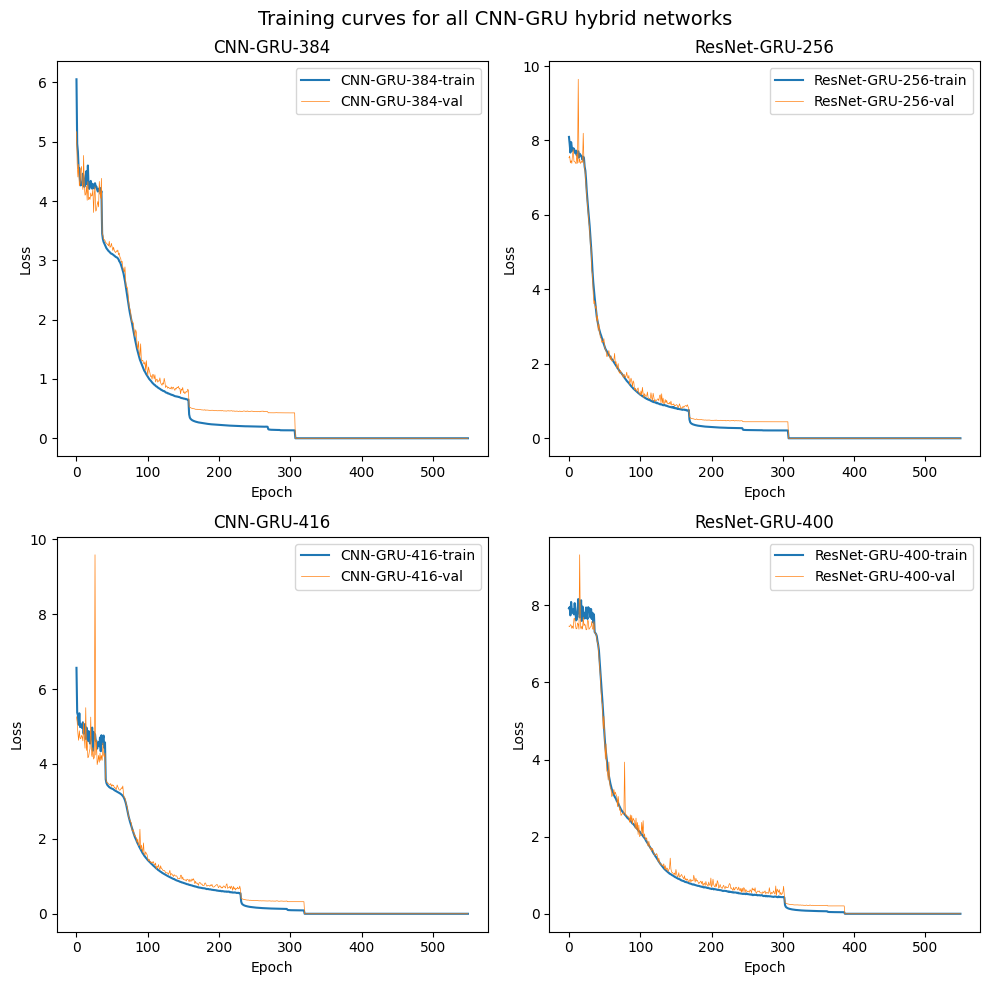

In [21]:
fig, ax = plt.subplots(2,2, figsize = (10, 10), tight_layout = True)
ax[0,0].plot(loss_dict_cnn_gru[['train_loss']], label = 'CNN-GRU-384-train')
ax[0,0].plot(loss_dict_cnn_gru[['test_loss']], label = 'CNN-GRU-384-val',linewidth = 0.5)
ax[0,0].set_xlabel('Epoch')
ax[0,0].set_ylabel('Loss')
ax[0,0].set_title('CNN-GRU-384')
ax[0,0].legend()

ax[0,1].plot(loss_dict_resnet_gru_256[['train_loss']], label = 'ResNet-GRU-256-train')
ax[0,1].plot(loss_dict_resnet_gru_256[['test_loss']], label = 'ResNet-GRU-256-val',linewidth = 0.5)
ax[0,1].set_title('ResNet-GRU-256')
ax[0,1].set_xlabel('Epoch')
ax[0,1].set_ylabel('Loss')
ax[0,1].legend()

ax[1,0].plot(loss_dict_cnn_gru_416[['train_loss']], label = 'CNN-GRU-416-train')
ax[1,0].plot(loss_dict_cnn_gru_416[['test_loss']], label = 'CNN-GRU-416-val',linewidth = 0.5)
ax[1,0].set_title('CNN-GRU-416')
ax[1,0].set_xlabel('Epoch')
ax[1,0].set_ylabel('Loss')
ax[1,0].legend()

ax[1,1].plot(loss_dict_resnet_gru_400[['train_loss']], label = 'ResNet-GRU-400-train')
ax[1,1].plot(loss_dict_resnet_gru_400[['test_loss']], label = 'ResNet-GRU-400-val',linewidth = 0.5)
ax[1,1].set_title('ResNet-GRU-400')
ax[1,1].set_xlabel('Epoch')
ax[1,1].set_ylabel('Loss')
ax[1,1].legend()

fig.suptitle('Training curves for all CNN-GRU hybrid networks', fontsize = 14)
plt.savefig('CNN_GRU-ResNet_GRU_train-val_losses')

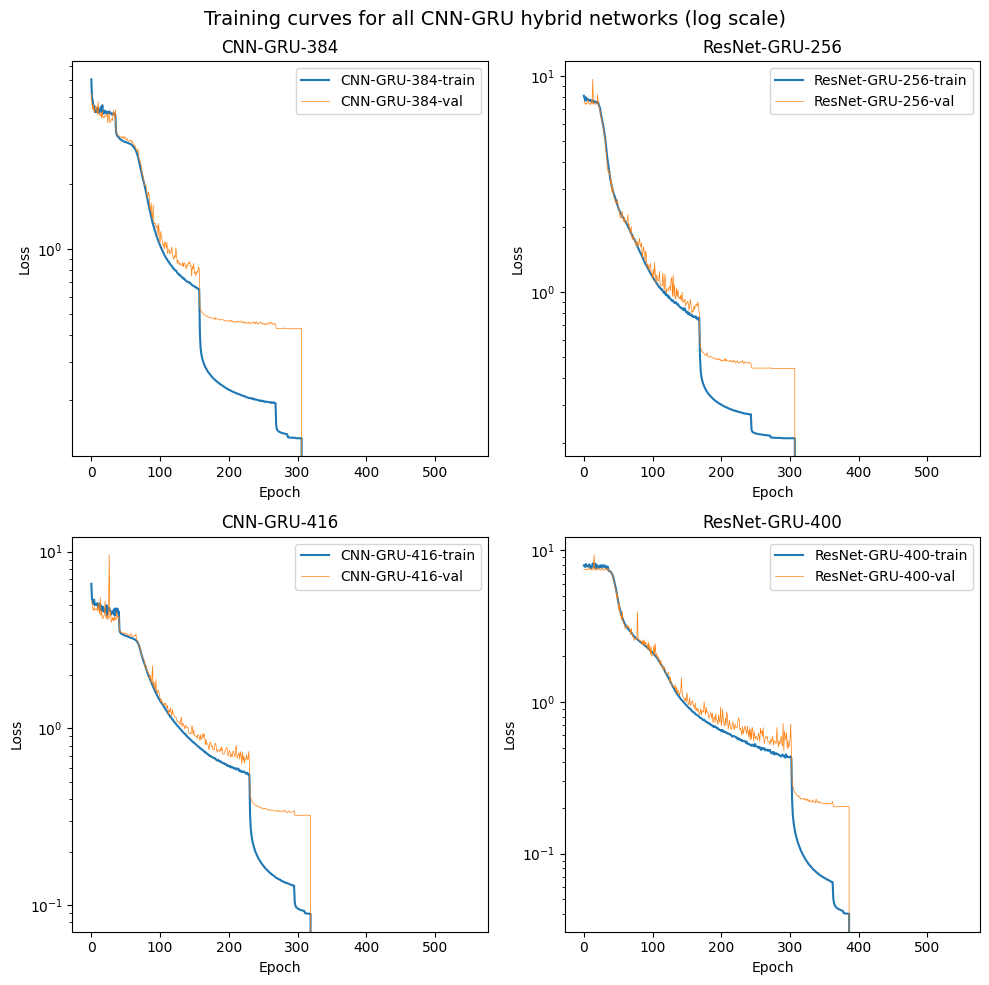

In [22]:
fig, ax = plt.subplots(2,2, figsize = (10, 10), tight_layout = True)
ax[0,0].plot(loss_dict_cnn_gru[['train_loss']], label = 'CNN-GRU-384-train')
ax[0,0].plot(loss_dict_cnn_gru[['test_loss']], label = 'CNN-GRU-384-val',linewidth = 0.5)
ax[0,0].set_xlabel('Epoch')
ax[0,0].set_ylabel('Loss')
ax[0,0].set_title('CNN-GRU-384')
ax[0,0].legend()
ax[0,0].set_yscale('log')

ax[0,1].plot(loss_dict_resnet_gru_256[['train_loss']], label = 'ResNet-GRU-256-train')
ax[0,1].plot(loss_dict_resnet_gru_256[['test_loss']], label = 'ResNet-GRU-256-val',linewidth = 0.5)
ax[0,1].set_title('ResNet-GRU-256')
ax[0,1].set_xlabel('Epoch')
ax[0,1].set_ylabel('Loss')
ax[0,1].legend()
ax[0,1].set_yscale('log')

ax[1,0].plot(loss_dict_cnn_gru_416[['train_loss']], label = 'CNN-GRU-416-train')
ax[1,0].plot(loss_dict_cnn_gru_416[['test_loss']], label = 'CNN-GRU-416-val',linewidth = 0.5)
ax[1,0].set_title('CNN-GRU-416')
ax[1,0].set_xlabel('Epoch')
ax[1,0].set_ylabel('Loss')
ax[1,0].legend()
ax[1,0].set_yscale('log')

ax[1,1].plot(loss_dict_resnet_gru_400[['train_loss']], label = 'ResNet-GRU-400-train')
ax[1,1].plot(loss_dict_resnet_gru_400[['test_loss']], label = 'ResNet-GRU-400-val',linewidth = 0.5)
ax[1,1].set_title('ResNet-GRU-400')
ax[1,1].set_xlabel('Epoch')
ax[1,1].set_ylabel('Loss')
ax[1,1].legend()
ax[1,1].set_yscale('log')

fig.suptitle('Training curves for all CNN-GRU hybrid networks (log scale)', fontsize = 14)
plt.savefig('CNN_GRU-ResNet_GRU_train-val_losses_logscale')


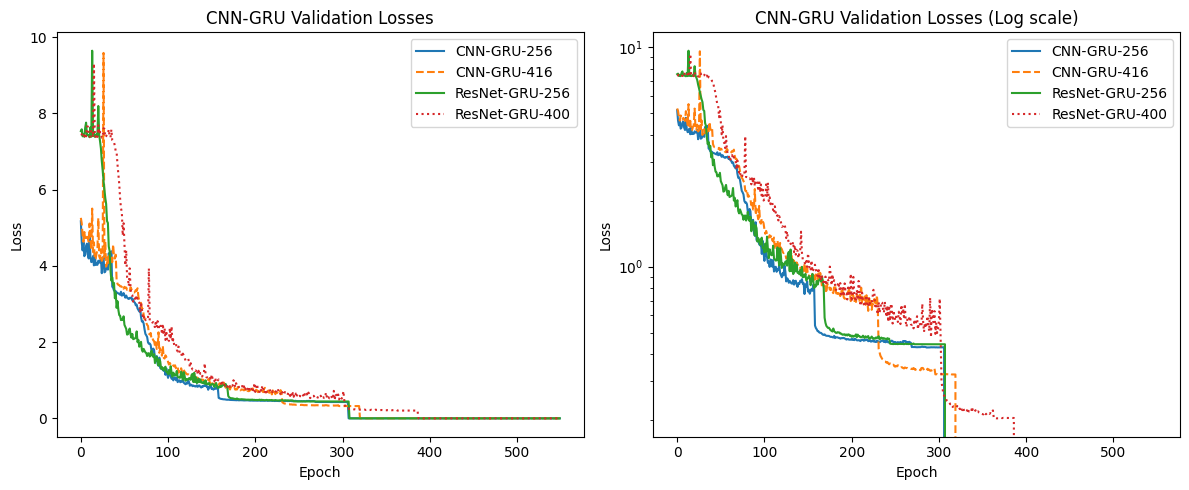

In [23]:
fig, ax = plt.subplots(1,2, figsize = (12,5), tight_layout = True)
ax[0].plot(loss_dict_cnn_gru[['test_loss']], label = 'CNN-GRU-256')
ax[0].plot(loss_dict_cnn_gru_416[['test_loss']], label = 'CNN-GRU-416', linestyle = 'dashed')
ax[0].plot(loss_dict_resnet_gru_256[['test_loss']], label = 'ResNet-GRU-256')
ax[0].plot(loss_dict_resnet_gru_400[['test_loss']], label = 'ResNet-GRU-400', linestyle = 'dotted')
ax[0].set_title('CNN-GRU Validation Losses')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(loss_dict_cnn_gru[['test_loss']], label = 'CNN-GRU-256')
ax[1].plot(loss_dict_cnn_gru_416[['test_loss']], label = 'CNN-GRU-416', linestyle = 'dashed')
ax[1].plot(loss_dict_resnet_gru_256[['test_loss']], label = 'ResNet-GRU-256')
ax[1].plot(loss_dict_resnet_gru_400[['test_loss']], label = 'ResNet-GRU-400',  linestyle = 'dotted')
ax[1].set_title('CNN-GRU Validation Losses (Log scale)')
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_yscale('log')
plt.savefig('CNN-GRU_all_losses')

# CNN-LSTM

In [24]:
class CNN_LSTM_hybrid(nn.Module):
    def __init__(self, cnn_block, lstm_block, feat_vec_size):
        super(CNN_LSTM_hybrid, self).__init__()
        self.cnn_block = cnn_block
        self.lstm_block = lstm_block
        self.feat_vec_size = feat_vec_size
        self.fc1 = nn.Linear(self.feat_vec_size, 1024)
        self.fc2 = nn.Linear(1024, 4)       
    def forward(self, x):
        #output of cnn block is (N,384)
        x1 = x.view(-1,1, 16,20)
        x1 = self.cnn_block(x1)
        #output of rnn block is (N,M)
        x2 = self.lstm_block(x)
        #concatenate the 2 outputs to produce a feat vec (N, M+384)
        xx = torch.cat([x1, x2], dim = 1)
        # pass through linear layers
        xx = self.fc1(xx)
        #final output is 4
        xx = self.fc2(xx)       
        return xx

In [25]:
loss_dict_cnn_lstm_256 = pd.read_csv('/kaggle/input/calabi-yau-cicy-4-folds/loss_dict_cnn_lstm_256.csv')
loss_dict_cnn_lstm_384 =pd.read_csv('/kaggle/input/calabi-yau-cicy-4-folds/loss_dict_cnn_lstm_384.csv')
loss_dict_cnn_lstm_400 =pd.read_csv('/kaggle/input/calabi-yau-cicy-4-folds/loss_dict_cnn_lstm_400.csv')
loss_dict_cnn_lstm_416 =pd.read_csv('/kaggle/input/calabi-yau-cicy-4-folds/loss_dict_cnn_lstm_416.csv')


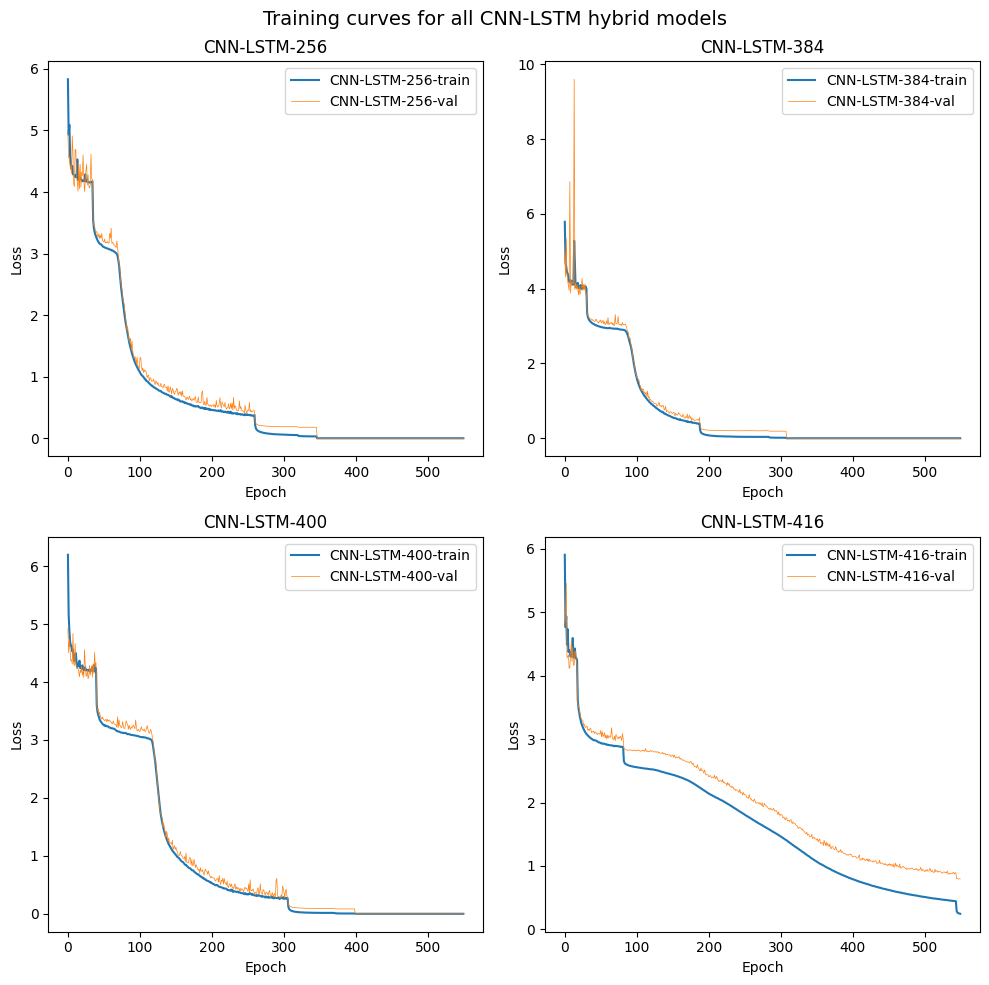

In [26]:
fig, ax = plt.subplots(2,2, figsize = (10,10), tight_layout = True)
ax[0,0].plot(loss_dict_cnn_lstm_256[['train_loss']], label = 'CNN-LSTM-256-train')
ax[0,0].plot(loss_dict_cnn_lstm_256[['val_loss']], label = 'CNN-LSTM-256-val',linewidth = 0.5)
ax[0,0].set_title('CNN-LSTM-256')
ax[0,0].set_xlabel('Epoch')
ax[0,0].set_ylabel('Loss')
ax[0,0].legend()

ax[0,1].plot(loss_dict_cnn_lstm_384[['train_loss']], label = 'CNN-LSTM-384-train')
ax[0,1].plot(loss_dict_cnn_lstm_384[['val_loss']], label = 'CNN-LSTM-384-val',linewidth = 0.5)
ax[0,1].set_title('CNN-LSTM-384')
ax[0,1].set_xlabel('Epoch')
ax[0,1].set_ylabel('Loss')
ax[0,1].legend()

ax[1,0].plot(loss_dict_cnn_lstm_400[['train_loss']], label = 'CNN-LSTM-400-train')
ax[1,0].plot(loss_dict_cnn_lstm_400[['val_loss']], label = 'CNN-LSTM-400-val',linewidth = 0.5)
ax[1,0].set_title('CNN-LSTM-400')
ax[1,0].set_xlabel('Epoch')
ax[1,0].set_ylabel('Loss')
ax[1,0].legend()

ax[1,1].plot(loss_dict_cnn_lstm_416[['train_loss']], label = 'CNN-LSTM-416-train')
ax[1,1].plot(loss_dict_cnn_lstm_416[['val_loss']], label = 'CNN-LSTM-416-val',linewidth = 0.5)
ax[1,1].set_title('CNN-LSTM-416')
ax[1,1].set_xlabel('Epoch')
ax[1,1].set_ylabel('Loss')
ax[1,1].legend()

plt.suptitle('Training curves for all CNN-LSTM hybrid models', fontsize = 14)
plt.savefig('CNN_LSTM_train-val_losses')


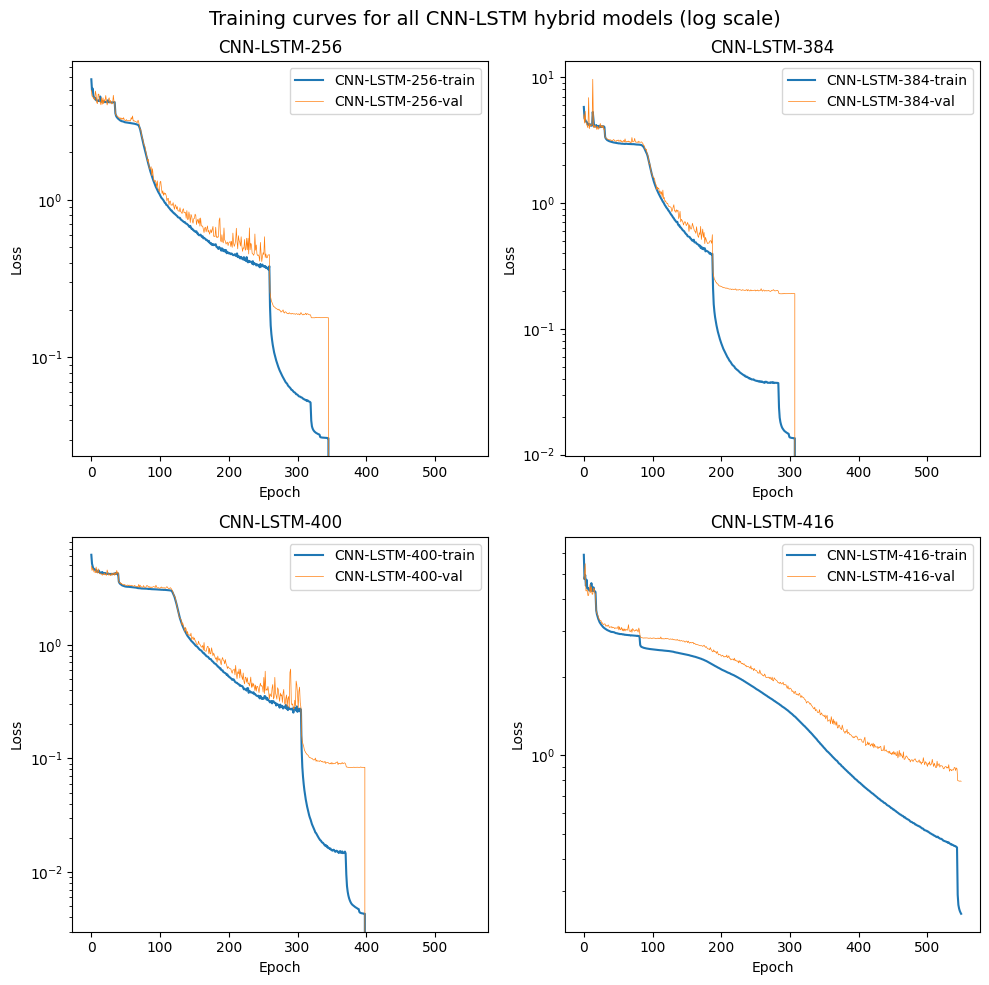

In [27]:
fig, ax = plt.subplots(2,2, figsize = (10,10), tight_layout = True)
ax[0,0].plot(loss_dict_cnn_lstm_256[['train_loss']], label = 'CNN-LSTM-256-train')
ax[0,0].plot(loss_dict_cnn_lstm_256[['val_loss']], label = 'CNN-LSTM-256-val',linewidth = 0.5)
ax[0,0].set_title('CNN-LSTM-256')
ax[0,0].legend()
ax[0,0].set_xlabel('Epoch')
ax[0,0].set_ylabel('Loss')
ax[0,0].set_yscale('log')


ax[0,1].plot(loss_dict_cnn_lstm_384[['train_loss']], label = 'CNN-LSTM-384-train')
ax[0,1].plot(loss_dict_cnn_lstm_384[['val_loss']], label = 'CNN-LSTM-384-val',linewidth = 0.5)
ax[0,1].set_title('CNN-LSTM-384')
ax[0,1].legend()
ax[0,1].set_xlabel('Epoch')
ax[0,1].set_ylabel('Loss')
ax[0,1].set_yscale('log')


ax[1,0].plot(loss_dict_cnn_lstm_400[['train_loss']], label = 'CNN-LSTM-400-train')
ax[1,0].plot(loss_dict_cnn_lstm_400[['val_loss']], label = 'CNN-LSTM-400-val', linewidth = 0.5)
ax[1,0].set_title('CNN-LSTM-400')
ax[1,0].legend()
ax[1,0].set_xlabel('Epoch')
ax[1,0].set_ylabel('Loss')
ax[1,0].set_yscale('log')

ax[1,1].plot(loss_dict_cnn_lstm_416[['train_loss']], label = 'CNN-LSTM-416-train')
ax[1,1].plot(loss_dict_cnn_lstm_416[['val_loss']], label = 'CNN-LSTM-416-val', linewidth = 0.5)
ax[1,1].set_title('CNN-LSTM-416')
ax[1,1].legend()
ax[1,1].set_xlabel('Epoch')
ax[1,1].set_ylabel('Loss')
ax[1,1].set_yscale('log')

plt.suptitle('Training curves for all CNN-LSTM hybrid models (log scale)', fontsize = 14)
plt.savefig('CNN_LSTM_train-val_losses_logscale')

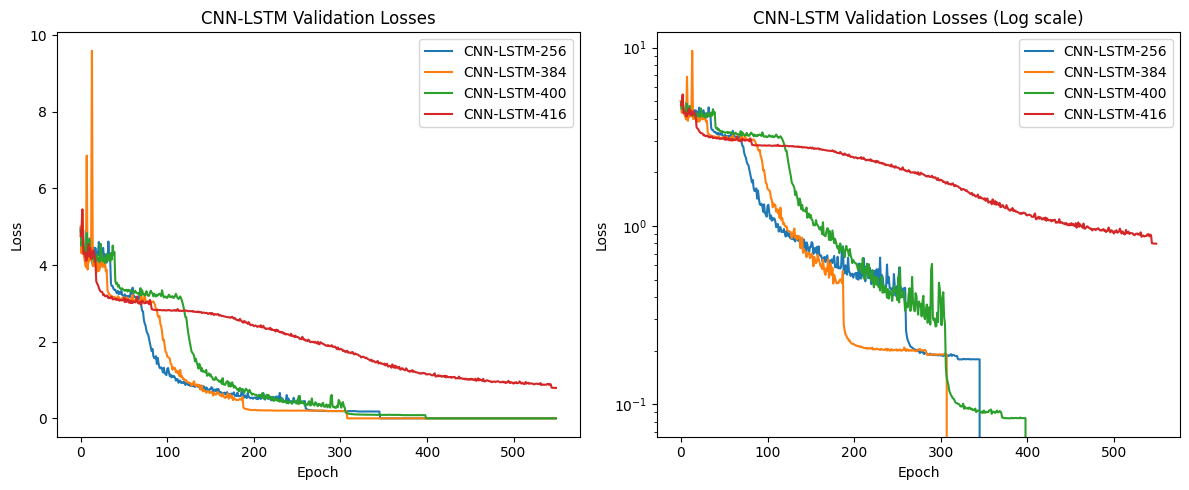

In [29]:
fig, ax = plt.subplots(1,2, figsize = (12,5), tight_layout = True)
ax[0].plot(loss_dict_cnn_lstm_256[['val_loss']], label = 'CNN-LSTM-256')
ax[0].plot(loss_dict_cnn_lstm_384[['val_loss']], label = 'CNN-LSTM-384')
ax[0].plot(loss_dict_cnn_lstm_400[['val_loss']], label = 'CNN-LSTM-400')
ax[0].plot(loss_dict_cnn_lstm_416[['val_loss']], label = 'CNN-LSTM-416')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('CNN-LSTM Validation Losses')
ax[0].legend()

ax[1].plot(loss_dict_cnn_lstm_256[['val_loss']], label = 'CNN-LSTM-256')
ax[1].plot(loss_dict_cnn_lstm_384[['val_loss']], label = 'CNN-LSTM-384')
ax[1].plot(loss_dict_cnn_lstm_400[['val_loss']], label = 'CNN-LSTM-400')
ax[1].plot(loss_dict_cnn_lstm_416[['val_loss']], label = 'CNN-LSTM-416')
ax[1].set_title('CNN-LSTM Validation Losses (Log scale)')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].set_yscale('log')
plt.savefig('CNN_LSTM_all_val_losses_logscale')

## CNN-LSTM-416

In [30]:
model_name = 'CNN-LSTM-416'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/CNN-LSTM-416.pt'
cnn_lstm_416,acctL416, accvL416, acctsL416 = load_model_and_get_pred(load_model_weight, model_name)


 Train accuracies for CNN-LSTM-416: [94.39204897468456, 81.82802426651455, 78.31793673285364, 37.013642246799535] 

 Validation accuracies for CNN-LSTM-416: [91.79214684976881, 77.56124491063419, 51.75074183976262, 16.607549513491133]

 Test accuracies for CNN-LSTM-416: [92.15290084300834, 77.59265086647123, 51.62059656503089, 16.37379442079752] 



## CNN-LSTM-400

In [31]:
model_name = 'CNN-LSTM-400'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/CNN-LSTM-400.pt'
cnn_lstm_400,acctL400, accvL400, acctsL400 = load_model_and_get_pred(load_model_weight, model_name)


 Train accuracies for CNN-LSTM-400: [99.98834520282414, 99.87808468743674, 99.94264612968722, 99.49961048441017] 

 Validation accuracies for CNN-LSTM-400: [99.71982609895798, 98.10917120971638, 95.18873783727831, 81.03926575115588]

 Test accuracies for CNN-LSTM-400: [99.74052788773139, 98.06831293440877, 95.18872455655112, 81.00719345026141] 



## CNN-LSTM-384

In [32]:
model_name = 'CNN-LSTM-384'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/CNN-LSTM-384.pt'
cnn_lstm_384,acctL384, accvL384, acctsL384 = load_model_and_get_pred(load_model_weight, model_name)


 Train accuracies for CNN-LSTM-384: [99.87977156597535, 98.8693313213473, 99.60803076866455, 94.21646025407458] 

 Validation accuracies for CNN-LSTM-384: [99.02698226485404, 94.66565454419985, 87.8614312331792, 62.31592022634739]

 Test accuracies for CNN-LSTM-384: [99.13049238973815, 94.76694435703362, 87.85284066756101, 62.32133688865334] 



## CNN-LSTM-256

In [33]:
model_name = 'CNN-LSTM-256'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/CNN-LSTM-256.pt'
cnn_lstm_256,acctL256, accvL256, acctsL256 = load_model_and_get_pred(load_model_weight, model_name)


 Train accuracies for CNN-LSTM-256: [99.74328775694227, 97.38993884298534, 98.60050422333046, 83.21923900308545] 

 Validation accuracies for CNN-LSTM-256: [99.30025533089504, 94.34545580015183, 88.53909323028087, 62.502242771375336]

 Test accuracies for CNN-LSTM-256: [99.30605011676245, 94.37387171036288, 88.60696599811193, 62.32740964021707] 



# LSTM 

In [34]:
class LSTM_block(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(LSTM_block,self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        self.lstm = nn.LSTM(input_size = self.D,
                           hidden_size = self.M,
                           num_layers = self.L,
                           batch_first = True)
        self.feat_vec_size = self.M
        self.fc1 = nn.Linear(self.feat_vec_size, 1024)
        self.fc2 = nn.Linear(1024, 4)
    def forward(self, X):
        #input X is NxTxD
        #initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        out, _ = self.lstm(X, (h0,c0))
        xx = out[:, -1, :]
        xx = self.fc1(xx)
        xx = self.fc2(xx)
        return xx

In [35]:
model_name = 'LSTM-400'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/LSTM-400.pt'
lstm_400, acctl400, accvl400, acctsl400 = load_model_and_get_pred(load_model_weight, model_name)


 Train accuracies for LSTM-400: [99.90814179594291, 98.33489752979641, 99.20946737576907, 88.90125933150537] 

 Validation accuracies for LSTM-400: [99.37754468290663, 94.3233731281485, 88.18439031122766, 65.0693533917604]

 Test accuracies for LSTM-400: [99.37837106720328, 94.13703439937726, 88.01018013989412, 65.04634613579776] 



In [36]:
model_name = 'LSTM-424'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/LSTM-424.pt'
lstm_424, acctl424, accvl424, acctsl424 = load_model_and_get_pred(load_model_weight, model_name)


 Train accuracies for LSTM-424: [99.98481809315251, 99.73960729467622, 99.9233237027904, 99.19443882151599] 

 Validation accuracies for LSTM-424: [99.59009040093851, 97.02297978055344, 93.18611551997792, 74.70291905320543]

 Test accuracies for LSTM-424: [99.56331395573517, 97.06630892639274, 93.1924454970547, 74.4668400161204] 



In [37]:
model_name = 'LSTM-448'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/LSTM-448.pt'
lstm_448, acctl448, accvl448, acctsl448 = load_model_and_get_pred(load_model_weight, model_name)


 Train accuracies for LSTM-448: [99.98021751531992, 99.78975359305129, 99.88927942682935, 99.21958864700073] 

 Validation accuracies for LSTM-448: [99.71982609895798, 97.35283969360292, 94.09426540611415, 78.44455179076668]

 Test accuracies for LSTM-448: [99.73500720449164, 97.51403633713709, 94.23585462936893, 78.62612276895389] 



In [38]:
model_name = 'LSTM-456'
load_model_weight = '/kaggle/input/calabi-yau-cicy-4-folds/LSTM-456.pt'
lstm_456, acctl456, accvl456, acctsl456 = load_model_and_get_pred(load_model_weight, model_name)


 Train accuracies for LSTM-456: [99.84833428411942, 98.05640921833115, 98.8941744416432, 85.95213558822988] 

 Validation accuracies for LSTM-456: [99.34028017390104, 94.106686909116, 87.95666275619351, 64.71879097370781]

 Test accuracies for LSTM-456: [99.3529759243004, 94.0133710948067, 87.77499903388043, 64.58150460701016] 



In [39]:
loss_dict_lstm_400 =pd.read_csv('/kaggle/input/calabi-yau-cicy-4-folds/loss_dict_lstm_400.csv')
loss_dict_lstm_424 =pd.read_csv('/kaggle/input/calabi-yau-cicy-4-folds/loss-dict-lstm-424.csv')
loss_dict_lstm_448 =pd.read_csv('/kaggle/input/calabi-yau-cicy-4-folds/loss-dict-lstm-448.csv')
loss_dict_lstm_456 =pd.read_csv('/kaggle/input/calabi-yau-cicy-4-folds/loss_dict_lstm_456.csv')

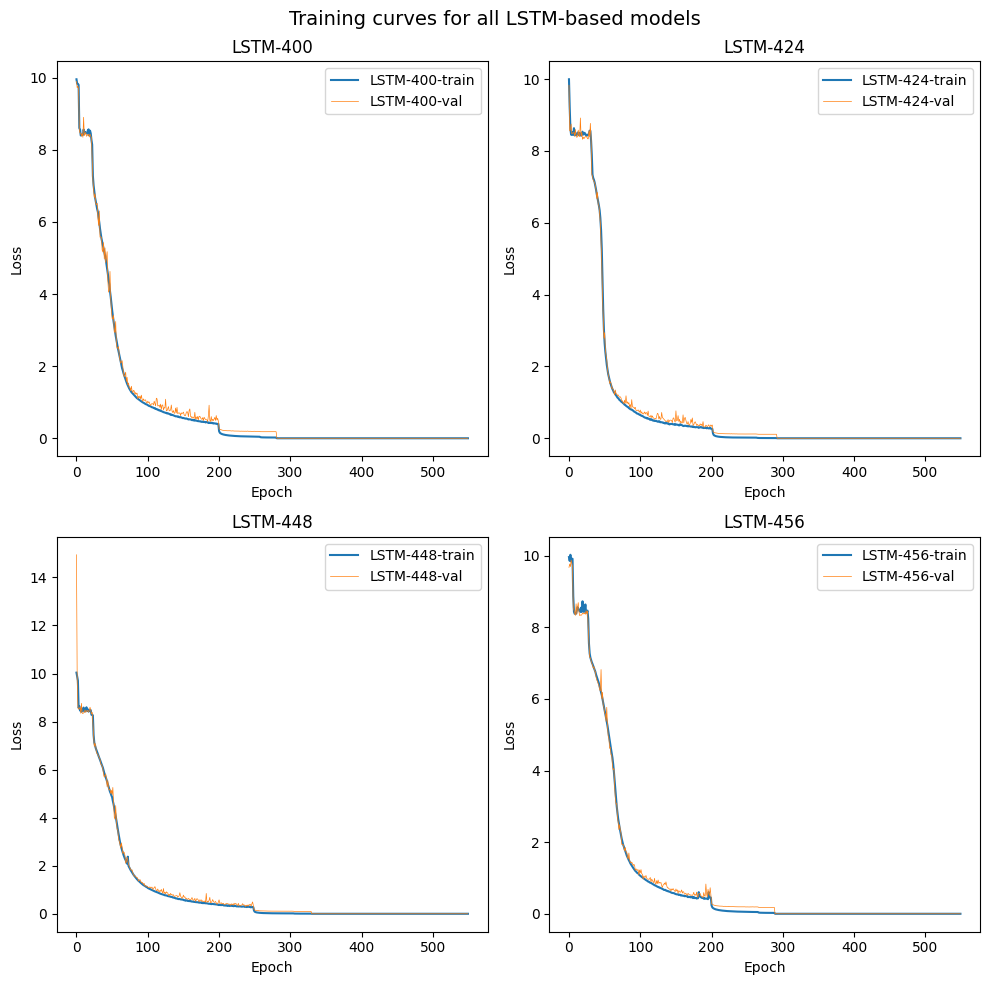

In [40]:
fig, ax = plt.subplots(2,2, figsize = (10,10), tight_layout = True)

ax[0,0].plot(loss_dict_lstm_400[['train_loss']], label = 'LSTM-400-train')
ax[0,0].plot(loss_dict_lstm_400[['test_loss']], label = 'LSTM-400-val',linewidth = 0.5)
ax[0,0].set_title('LSTM-400')
ax[0,0].set_xlabel('Epoch')
ax[0,0].set_ylabel('Loss')
ax[0,0].legend()

ax[0,1].plot(loss_dict_lstm_424[['train_loss']], label = 'LSTM-424-train')
ax[0,1].plot(loss_dict_lstm_424[['test_loss']], label = 'LSTM-424-val',linewidth = 0.5)
ax[0,1].set_title('LSTM-424')
ax[0,1].set_xlabel('Epoch')
ax[0,1].set_ylabel('Loss')
ax[0,1].legend()

ax[1,0].plot(loss_dict_lstm_448[['train_loss']], label = 'LSTM-448-train')
ax[1,0].plot(loss_dict_lstm_448[['test_loss']], label = 'LSTM-448-val',linewidth = 0.5)
ax[1,0].set_title('LSTM-448')
ax[1,0].set_xlabel('Epoch')
ax[1,0].set_ylabel('Loss')
ax[1,0].legend()

ax[1,1].plot(loss_dict_lstm_456[['train_loss']], label = 'LSTM-456-train')
ax[1,1].plot(loss_dict_lstm_456[['test_loss']], label = 'LSTM-456-val',linewidth = 0.5)
ax[1,1].set_title('LSTM-456')
ax[1,1].set_xlabel('Epoch')
ax[1,1].set_ylabel('Loss')
ax[1,1].legend()
plt.suptitle('Training curves for all LSTM-based models', fontsize = 14)
plt.savefig('LSTM_train-val_losses_all')

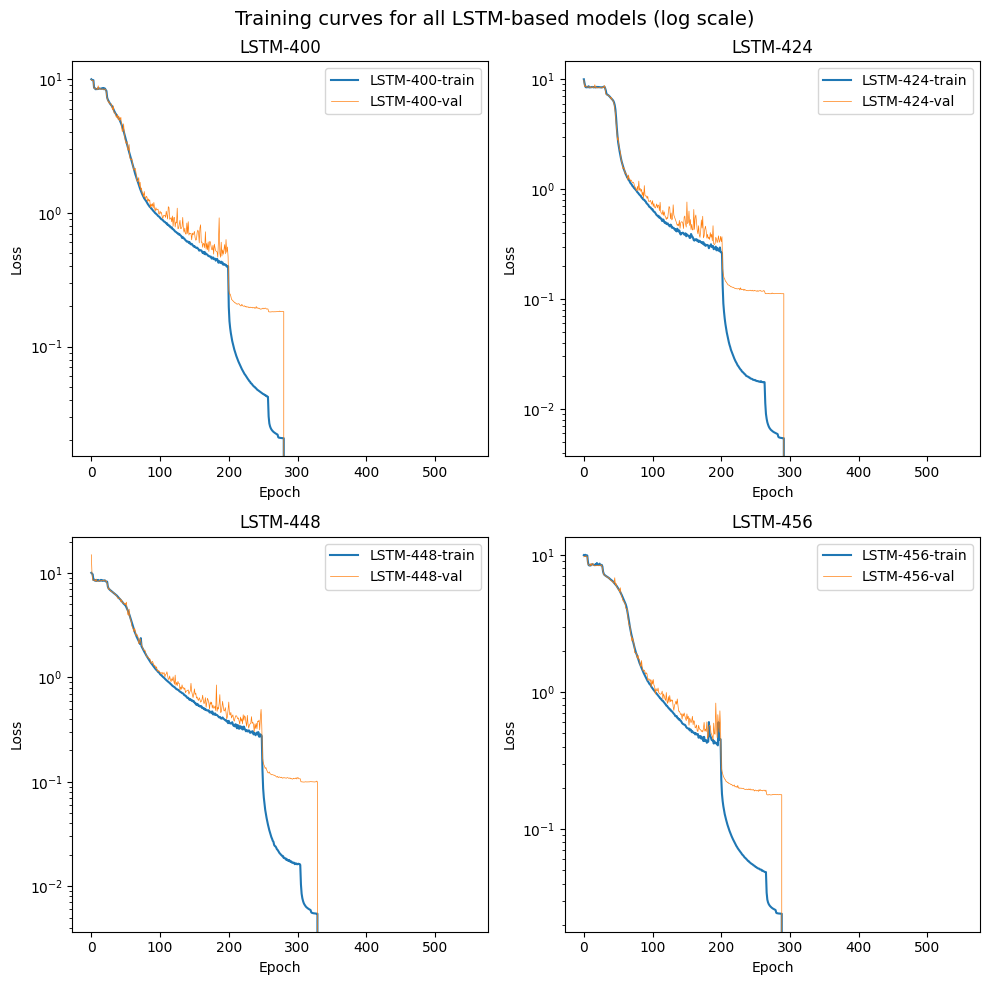

In [41]:
fig, ax = plt.subplots(2,2, figsize = (10,10), tight_layout = True)

ax[0,0].plot(loss_dict_lstm_400[['train_loss']], label = 'LSTM-400-train')
ax[0,0].plot(loss_dict_lstm_400[['test_loss']], label = 'LSTM-400-val',linewidth = 0.5)
ax[0,0].set_title('LSTM-400')
ax[0,0].set_xlabel('Epoch')
ax[0,0].set_ylabel('Loss')
ax[0,0].legend()
ax[0,0].set_yscale('log')

ax[0,1].plot(loss_dict_lstm_424[['train_loss']], label = 'LSTM-424-train')
ax[0,1].plot(loss_dict_lstm_424[['test_loss']], label = 'LSTM-424-val',linewidth = 0.5)
ax[0,1].set_title('LSTM-424')
ax[0,1].set_xlabel('Epoch')
ax[0,1].set_ylabel('Loss')
ax[0,1].legend()
ax[0,1].set_yscale('log')

ax[1,0].plot(loss_dict_lstm_448[['train_loss']], label = 'LSTM-448-train')
ax[1,0].plot(loss_dict_lstm_448[['test_loss']], label = 'LSTM-448-val',linewidth = 0.5)
ax[1,0].set_title('LSTM-448')
ax[1,0].set_xlabel('Epoch')
ax[1,0].set_ylabel('Loss')
ax[1,0].legend()
ax[1,0].set_yscale('log')

ax[1,1].plot(loss_dict_lstm_456[['train_loss']], label = 'LSTM-456-train')
ax[1,1].plot(loss_dict_lstm_456[['test_loss']], label = 'LSTM-456-val',linewidth = 0.5)
ax[1,1].set_title('LSTM-456')
ax[1,1].set_xlabel('Epoch')
ax[1,1].set_ylabel('Loss')
ax[1,1].legend()
ax[1,1].set_yscale('log')

plt.suptitle('Training curves for all LSTM-based models (log scale)', fontsize = 14)
plt.savefig('LSTM_train-val_losses_logscale')

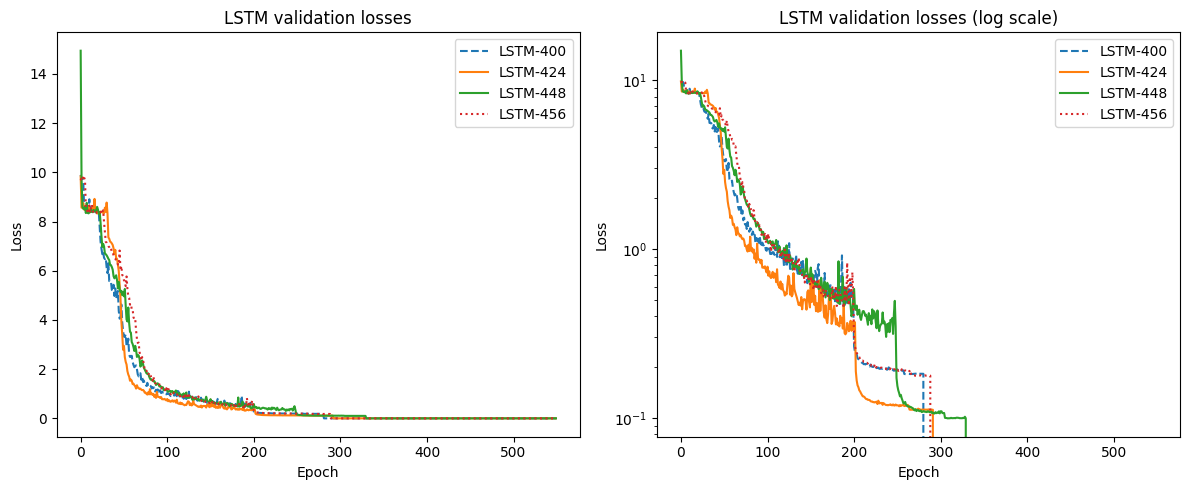

In [42]:
###### 
fig, ax = plt.subplots(1,2, figsize = (12, 5), tight_layout = True)
ax[0].plot(loss_dict_lstm_400[['test_loss']], label = 'LSTM-400', linestyle = 'dashed')
ax[0].plot(loss_dict_lstm_424[['test_loss']], label = 'LSTM-424')
ax[0].plot(loss_dict_lstm_448[['test_loss']], label = 'LSTM-448')
ax[0].plot(loss_dict_lstm_456[['test_loss']], label = 'LSTM-456', linestyle = 'dotted')
ax[0].set_title('LSTM validation losses')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(loss_dict_lstm_400[['test_loss']], label = 'LSTM-400', linestyle = 'dashed')
ax[1].plot(loss_dict_lstm_424[['test_loss']], label = 'LSTM-424')
ax[1].plot(loss_dict_lstm_448[['test_loss']], label = 'LSTM-448')
ax[1].plot(loss_dict_lstm_456[['test_loss']], label = 'LSTM-456', linestyle = 'dotted')
ax[1].set_title('LSTM validation losses (log scale)')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].set_yscale('log')
plt.savefig('LSTM_train-val_losses')

# LSTM vs GRU

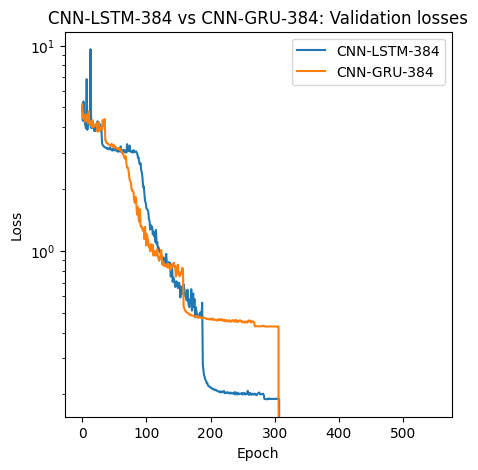

In [43]:
###### 
fig, ax = plt.subplots(1,1, figsize = (5,5))
ax.plot(loss_dict_cnn_lstm_384[['val_loss']], label = 'CNN-LSTM-384')
ax.plot(loss_dict_cnn_gru[['test_loss']], label = 'CNN-GRU-384')
ax.set_title('CNN-LSTM-384 vs CNN-GRU-384: Validation losses')
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.savefig('LSTM_vs_GRU')

# Ensemble of best models

In [44]:
yts_ens_1, tgts_ens_1, accts_ens_1 = get_pred_n_acc([cnn_lstm_400, lstm_448], device, test_loader, num_iter = len(test_loader))
yt_ens_1, tgt_ens_1, acct_ens_1 = get_pred_n_acc([cnn_lstm_400, lstm_448], device, train_loader, num_iter = len(train_loader))
print(f'Train accuracy of first ensemble: {acct_ens_1}')
print(f'Test accuracy of first ensemble: {accts_ens_1}')

Train accuracy of first ensemble: [99.99187231249577, 99.87808468743674, 99.91504266269176, 99.74420787250878]
Test accuracy of first ensemble: [99.80401574498859, 98.32447263673352, 95.72423083080763, 82.92507880775325]


In [45]:
yts_ens_2, tgts_ens_2, accts_ens_2 = get_pred_n_acc([lstm_424, lstm_448,cnn_lstm_400], device, test_loader, num_iter = len(test_loader))
yt_ens_2, tgt_ens_2, acct_ens_2 = get_pred_n_acc([lstm_424, lstm_448, cnn_lstm_400], device, train_loader, num_iter = len(train_loader))
print(f'Train accuracy of 2nd ensemble: {acct_ens_2}')
print(f'Test accuracy of 2nd ensemble: {accts_ens_2}')

Train accuracy of 2nd ensemble: [99.99294578065671, 99.88851266385724, 99.91028873226477, 99.78147255295265]
Test accuracy of 2nd ensemble: [99.7973909251009, 98.39844979214628, 95.79047902968472, 83.01893042282913]


In [46]:
yts_ens_3, tgts_ens_3, accts_ens_3 = get_pred_n_acc([cnn_lstm_400, lstm_448,cnn_lstm_384, lstm_424], device, test_loader, num_iter = len(test_loader))
yt_ens_3, tgt_ens_3, acct_ens_3 = get_pred_n_acc([cnn_lstm_400, lstm_448, cnn_lstm_384, lstm_424], device, train_loader, num_iter = len(train_loader))
print(f'Train accuracy of 3rd ensemble: {acct_ens_3}')
print(f'Test accuracy of 3rd ensemble: {accts_ens_3}')

Train accuracy of 3rd ensemble: [99.99187231249577, 99.85278150935758, 99.89065960017912, 99.64391527575863]
Test accuracy of 3rd ensemble: [99.78414128532546, 98.2157151769103, 95.21522383610196, 80.16915373446618]


In [47]:
yts_ens_4, tgts_ens_4, accts_ens_4 = get_pred_n_acc([cnn_lstm_400, lstm_448,lstm_456, lstm_424], device, test_loader, num_iter = len(test_loader))
yt_ens_4, tgt_ens_4, acct_ens_4 = get_pred_n_acc([cnn_lstm_400, lstm_448, lstm_456, lstm_424], device, train_loader, num_iter = len(train_loader))
print(f'Train accuracy of 4th ensemble: {acct_ens_4}')
print(f'Test accuracy of 4th ensemble: {accts_ens_4}')

Train accuracy of 4th ensemble: [99.98497144574692, 99.81060954589229, 99.84971445746919, 99.12098292878919]
Test accuracy of 4th ensemble: [99.75488166415477, 98.12793631339815, 95.16664182359209, 80.19013233077726]


# Comparison of accuracies of all models

In [48]:
test_acc_all = np.array([acctsG384,acctsG416, acctsR256, acctsR400, acctsL256, acctsL384, acctsL400, 
                         acctsl400, acctsl424, acctsl448, acctsl456,
                        accts_ens_1, accts_ens_2,accts_ens_3])

train_acc_all = np.array([acctG384,acctG416, acctR256, acctR400, acctL256, acctL384, acctL400,
                         acctl400, acctl424, acctl448, acctl456,
                         acct_ens_1,acct_ens_2,acct_ens_3])


In [49]:
test_acc_all 

array([[98.23724584, 84.83578728, 69.29285568, 31.7339914 ],
       [98.25435996, 88.63732976, 77.68981489, 45.37063107],
       [97.87398488, 84.05240233, 69.54128643, 37.1420527 ],
       [99.22323987, 92.45488222, 86.61952003, 59.44340472],
       [99.30605012, 94.37387171, 88.606966  , 62.32740964],
       [99.13049239, 94.76694436, 87.85284067, 62.32133689],
       [99.74052789, 98.06831293, 95.18872456, 81.00719345],
       [99.37837107, 94.1370344 , 88.01018014, 65.04634614],
       [99.56331396, 97.06630893, 93.1924455 , 74.46684002],
       [99.7350072 , 97.51403634, 94.23585463, 78.62612277],
       [99.35297592, 94.01337109, 87.77499903, 64.58150461],
       [99.80401574, 98.32447264, 95.72423083, 82.92507881],
       [99.79739093, 98.39844979, 95.79047903, 83.01893042],
       [99.78414129, 98.21571518, 95.21522384, 80.16915373]])

In [50]:
train_acc_all

array([[98.98495918, 88.97364176, 89.20213712, 53.39323286],
       [99.00520172, 92.24097213, 92.83107292, 63.72444379],
       [98.40206597, 86.79296786, 82.04900536, 48.08140569],
       [99.75908307, 95.9955037 , 97.74310987, 79.07902566],
       [99.74328776, 97.38993884, 98.60050422, 83.219239  ],
       [99.87977157, 98.86933132, 99.60803077, 94.21646025],
       [99.9883452 , 99.87808469, 99.94264613, 99.49961048],
       [99.9081418 , 98.33489753, 99.20946738, 88.90125933],
       [99.98481809, 99.73960729, 99.9233237 , 99.19443882],
       [99.98021752, 99.78975359, 99.88927943, 99.21958865],
       [99.84833428, 98.05640922, 98.89417444, 85.95213559],
       [99.99187231, 99.87808469, 99.91504266, 99.74420787],
       [99.99294578, 99.88851266, 99.91028873, 99.78147255],
       [99.99187231, 99.85278151, 99.8906596 , 99.64391528]])

In [51]:
mds = ['CNN-GRU-384','CNN-GRU-416', 'ResNet-GRU-256', 'ResNet-GRU-400',
    'CNN-LSTM-256', 'CNN-LSTM-384', 
       'CNN-LSTM-400',
     'LSTM-400','LSTM-424','LSTM-448','LSTM-456',
       'Ensemble-1', 'Ensemble-2', 'Ensemble-3' ]
acc_dict = {'Train_h11': train_acc_all[:,0],'Train_h21': train_acc_all[:,1],
            'Train_h31': train_acc_all[:,2], 'Train_h22': train_acc_all[:,3],
            'Test_h11':test_acc_all[:,0], 'Test_h21':test_acc_all[:,1],'Test_h31':test_acc_all[:,2],
           'Test_h22':test_acc_all[:,3]}
df = pd.DataFrame(acc_dict, index = mds)
df.to_csv('train_test_all.csv')
df

,Train_h11,Train_h21,Train_h31,Train_h22,Test_h11,Test_h21,Test_h31,Test_h22
CNN-GRU-384,98.984959,88.973642,89.202137,53.393233,98.237246,84.835787,69.292856,31.733991
CNN-GRU-416,99.005202,92.240972,92.831073,63.724444,98.254360,88.637330,77.689815,45.370631
ResNet-GRU-256,98.402066,86.792968,82.049005,48.081406,97.873985,84.052402,69.541286,37.142053
ResNet-GRU-400,99.759083,95.995504,97.743110,79.079026,99.223240,92.454882,86.619520,59.443405
CNN-LSTM-256,99.743288,97.389939,98.600504,83.219239,99.306050,94.373872,88.606966,62.327410
CNN-LSTM-384,99.879772,98.869331,99.608031,94.216460,99.130492,94.766944,87.852841,62.321337
CNN-LSTM-400,99.988345,99.878085,99.942646,99.499610,99.740528,98.068313,95.188725,81.007193
LSTM-400,99.908142,98.334898,99.209467,88.901259,99.378371,94.137034,88.010180,65.046346
LSTM-424,99.984818,99.739607,99.923324,99.194439,99.563314,97.066309,93.192445,74.466840
LSTM-448,99.980218,99.789754,99.889279,99.219589,99.735007,97.514036,94.235855,78.626123


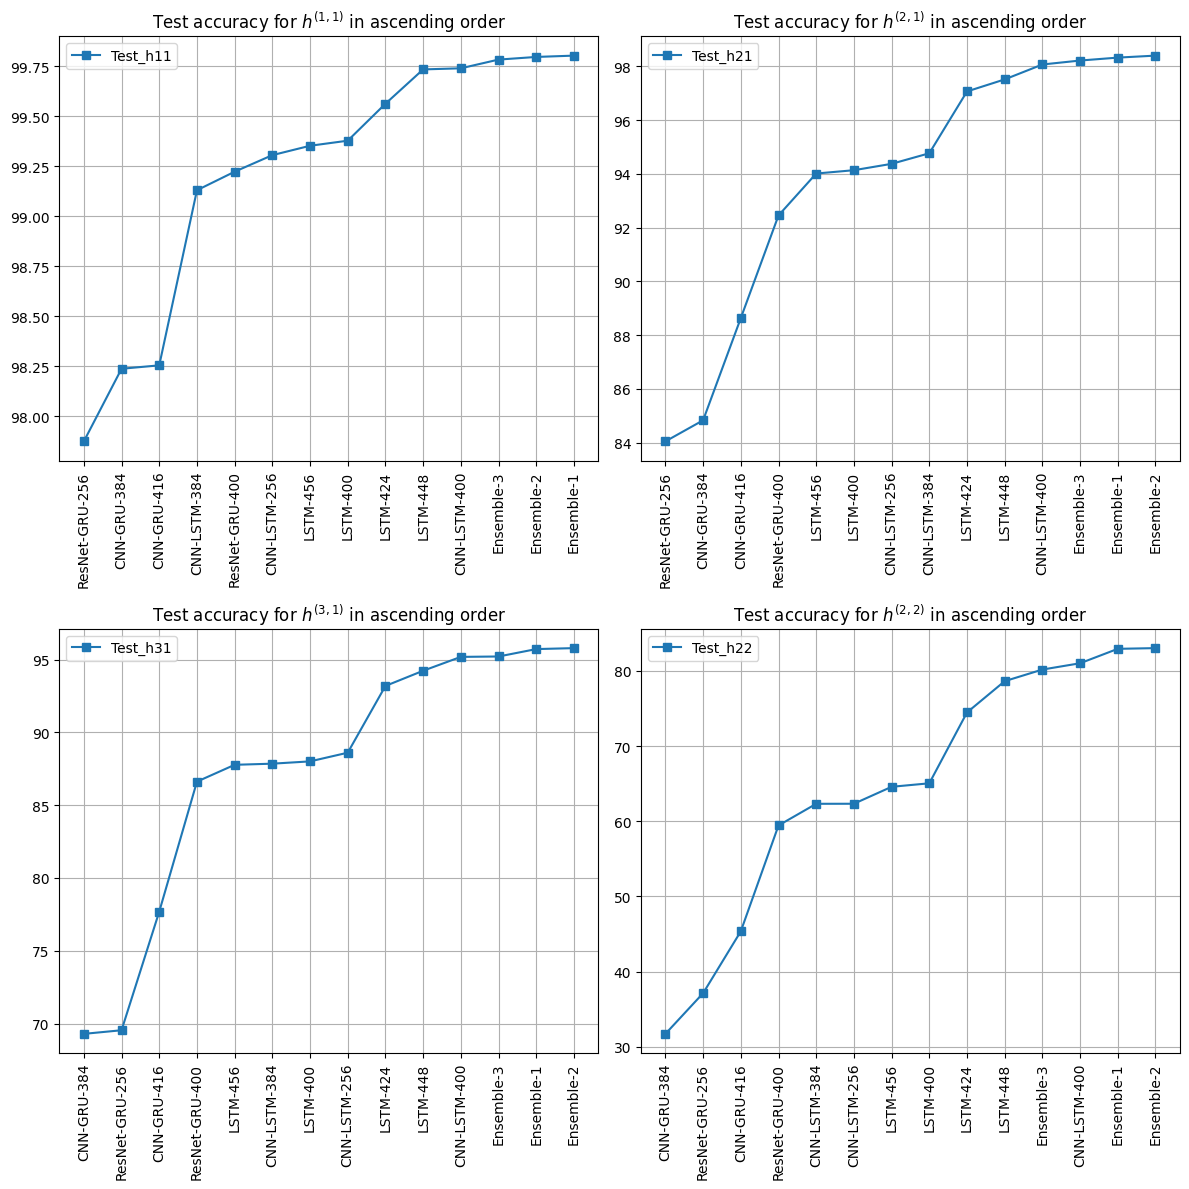

In [52]:
df_tr11 = df['Train_h11'].sort_values(ascending = True)
df_t11 = df['Test_h11'].sort_values(ascending = True)

df_tr21 = df['Train_h21'].sort_values(ascending = True)
df_t21 = df['Test_h21'].sort_values(ascending = True)

df_tr31 = df['Train_h31'].sort_values(ascending = True)
df_t31 = df['Test_h31'].sort_values(ascending = True)

df_tr22 = df['Train_h22'].sort_values(ascending = True)
df_t22 = df['Test_h22'].sort_values(ascending = True)

fig, ax = plt.subplots(2,2, figsize = (12,12), tight_layout = True)

#df_tr11.plot(ax = ax[0,0], style='D-')
df_t11.plot(ax = ax[0,0], style='s-')
ax[0,0].grid()
ax[0,0].set_title('Test accuracy for $h^{(1,1)}$ in ascending order')
ax[0,0].set_xticks(range(len(df.index)))
ax[0,0].set_xticklabels(df_t11.index)
ax[0,0].tick_params(axis='x', labelrotation=90)
ax[0,0].legend()


#df_tr21.plot(ax = ax[0,1],style='D-')
df_t21.plot(ax = ax[0,1],style='s-')
ax[0,1].grid()
ax[0,1].set_title('Test accuracy for $h^{(2,1)}$ in ascending order')
ax[0,1].tick_params(axis='x', labelrotation=90)
ax[0,1].set_xticks(range(len(df.index)))
ax[0,1].set_xticklabels(df_t21.index)
ax[0,1].set_xticks(range(len(df.index)))
ax[0,1].legend()

#df_tr31.plot(ax = ax[1,0],style='D-')
df_t31.plot(ax = ax[1,0],style='s-')
ax[1,0].grid()
ax[1,0].set_title('Test accuracy for $h^{(3,1)}$ in ascending order')
ax[1,0].tick_params(axis='x', labelrotation=90)
ax[1,0].set_xticks(range(len(df.index)))
ax[1,0].set_xticklabels(df_t31.index)
ax[1,0].set_xticks(range(len(df.index)))
ax[1,0].legend()

#df_tr22.plot(ax = ax[1,1],style='D-')
df_t22.plot(ax = ax[1,1],style='s-')
ax[1,1].grid()
ax[1,1].set_title('Test accuracy for $h^{(2,2)}$ in ascending order')
ax[1,1].tick_params(axis='x', labelrotation=90)
ax[1,1].set_xticks(range(len(df.index)))
ax[1,1].set_xticklabels(df_t22.index)
ax[1,1].set_xticks(range(len(df.index)))
ax[1,1].legend()
plt.savefig('Train_test_accuracies_all')

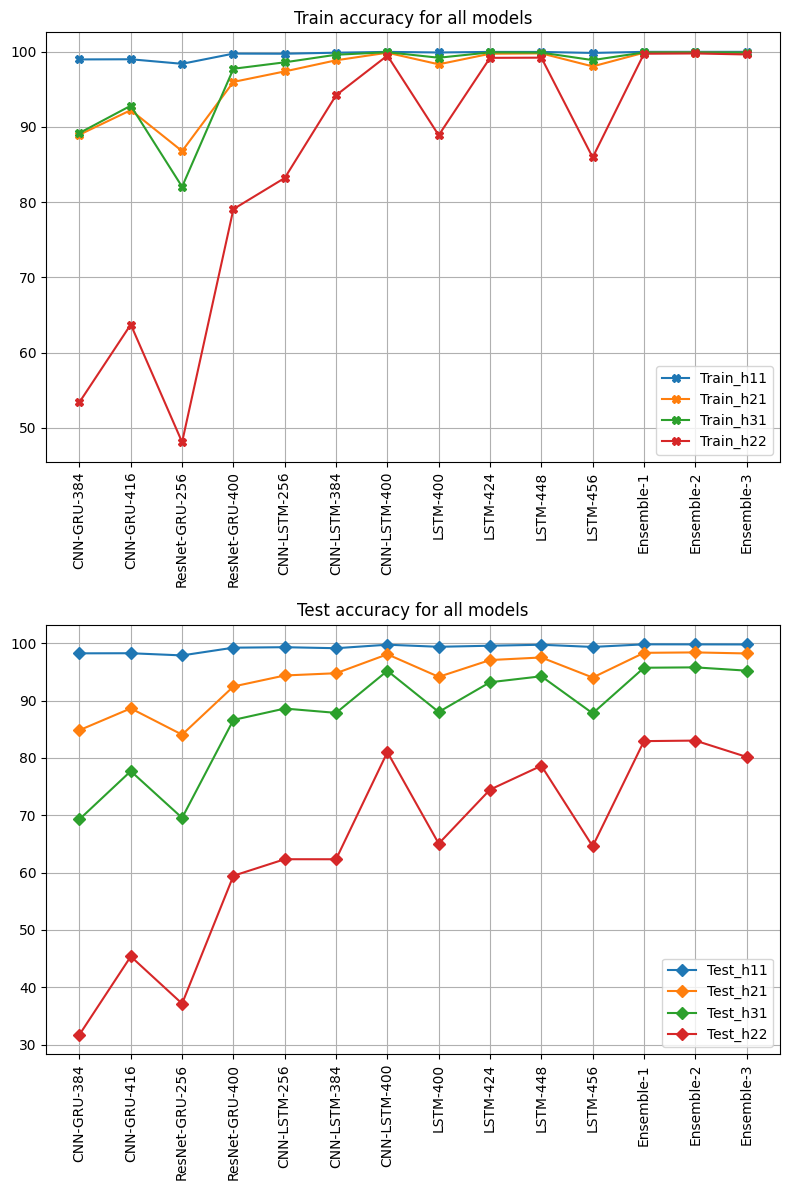

In [53]:
#fig, ax = plt.subplots(2,1, figsize = (14,10), sharex = True)
fig, ax = plt.subplots(2,1, figsize = (8,12), tight_layout = True)
#df['Test_h11'].sort_values(ascending = True).plot(ax = ax[0], style='X-')
df['Train_h11'].plot(ax = ax[0], style='X-')
df['Train_h21'].plot(ax = ax[0],style='X-')
df['Train_h31'].plot(ax = ax[0],style='X-')
df['Train_h22'].plot(ax = ax[0],style='X-')
ax[0].grid()
ax[0].set_title('Train accuracy for all models')
ax[0].tick_params(axis='x', labelrotation=90)
ax[0].set_xticks(range(len(df.index)))
ax[0].set_xticklabels(df.index)
#ax[0].set_xticks(range(len(df.index)))
ax[0].legend(loc = 'lower right')


df['Test_h11'].plot(ax = ax[1], style='D-')
df['Test_h21'].plot(ax = ax[1],style='D-')
df['Test_h31'].plot(ax = ax[1],style='D-')
df['Test_h22'].plot(ax = ax[1],style='D-')
ax[1].grid()
ax[1].set_title('Test accuracy for all models')
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].set_xticks(range(len(df.index)))
ax[1].set_xticklabels(df.index)
ax[1].set_xticks(range(len(df.index)))
ax[1].legend()

#ax[0].get_shared_x_axes().join(ax[0], ax[1])
plt.savefig('Train_test_4x_accuracies_all')

# Comparison of last val loss

In [54]:
loss_list = [loss_dict_cnn_gru,loss_dict_cnn_gru_416, loss_dict_resnet_gru_256,loss_dict_resnet_gru_400, 
            loss_dict_cnn_lstm_256, loss_dict_cnn_lstm_384, loss_dict_cnn_lstm_400, 
             loss_dict_lstm_400, loss_dict_lstm_424,loss_dict_lstm_448, loss_dict_lstm_456]

name_list = mds

loss_dict = {name_list[i]: loss_list[i] for i in range(len(loss_list))}
loss_dict.keys()

dict_keys(['CNN-GRU-384', 'CNN-GRU-416', 'ResNet-GRU-256', 'ResNet-GRU-400', 'CNN-LSTM-256', 'CNN-LSTM-384', 'CNN-LSTM-400', 'LSTM-400', 'LSTM-424', 'LSTM-448', 'LSTM-456'])

In [55]:
loss_dict.items()

dict_items([('CNN-GRU-384',      train_loss  test_loss
0      6.053329   5.169710
1      4.966186   4.623202
2      4.832945   4.405545
3      4.547861   4.619461
4      4.552969   4.254152
..          ...        ...
545    0.000000   0.000000
546    0.000000   0.000000
547    0.000000   0.000000
548    0.000000   0.000000
549    0.000000   0.000000

[550 rows x 2 columns]), ('CNN-GRU-416',      train_loss  test_loss
0      6.567251   5.259535
1      5.372093   5.117800
2      5.297484   4.811018
3      5.049404   4.631702
4      5.354156   4.887341
..          ...        ...
545    0.000000   0.000000
546    0.000000   0.000000
547    0.000000   0.000000
548    0.000000   0.000000
549    0.000000   0.000000

[550 rows x 2 columns]), ('ResNet-GRU-256',      train_loss  test_loss
0      8.095614   7.536214
1      7.905347   7.582742
2      7.675314   7.398756
3      7.955924   7.457435
4      7.815083   7.385577
..          ...        ...
545    0.000000   0.000000
546    0.000000   0.0

In [56]:
loss_dict_cnn_lstm_256.columns = ['train_loss', 'test_loss']
loss_dict_cnn_lstm_400.columns = ['train_loss', 'test_loss']
loss_dict_cnn_lstm_384.columns = ['train_loss', 'test_loss']

In [57]:
#write a function to check for the last nonzero value
def check_last_nonzero(df, model_name):
    for i in range(len(df)):
        if df['train_loss'][i] == 0 and df['train_loss'][i+1] == 0:
            return model_name, i-1, df['train_loss'][i-1], df['test_loss'][i-1]

In [58]:
last_val_list = [check_last_nonzero(loss_list[i], name_list[i]) for i in range(len(loss_list))]
last_val_list

[('CNN-GRU-384', 306, 0.1337970497008044, 0.4283022789622951),
 ('CNN-GRU-416', 319, 0.0894559652497946, 0.3220232229883498),
 ('ResNet-GRU-256', 307, 0.2098858948032919, 0.4422456975862042),
 ('ResNet-GRU-400', 386, 0.0401238790269981, 0.2039496767904602),
 ('CNN-LSTM-256', 345, 0.0306385038248734, 0.1785419213715316),
 ('CNN-LSTM-384', 307, 0.0134794706793116, 0.1899900773188634),
 ('CNN-LSTM-400', 398, 0.0043023051301033, 0.0835543588342595),
 ('LSTM-400', 280, 0.0206438472146265, 0.1825886086233919),
 ('LSTM-424', 291, 0.0054046038589856, 0.1117993761675277),
 ('LSTM-448', 329, 0.0054459169049134, 0.0996007998163912),
 ('LSTM-456', 288, 0.0241062974712653, 0.178004607321724)]

In [59]:
#write a new csv file
mds2 = [last_val_list[i][0] for i in range(len(last_val_list))]
last_train =[last_val_list[i][2] for i in range(len(last_val_list))]
last_test =[last_val_list[i][3] for i in range(len(last_val_list))]
mds2

['CNN-GRU-384',
 'CNN-GRU-416',
 'ResNet-GRU-256',
 'ResNet-GRU-400',
 'CNN-LSTM-256',
 'CNN-LSTM-384',
 'CNN-LSTM-400',
 'LSTM-400',
 'LSTM-424',
 'LSTM-448',
 'LSTM-456']

In [60]:
val_dict = {'last_train': last_train, 'last_val': last_test}
df2 = pd.DataFrame(val_dict, index = mds2)
df2.to_csv('train_test_last_val.csv')
df2

,last_train,last_val
CNN-GRU-384,0.133797,0.428302
CNN-GRU-416,0.089456,0.322023
ResNet-GRU-256,0.209886,0.442246
ResNet-GRU-400,0.040124,0.203950
CNN-LSTM-256,0.030639,0.178542
CNN-LSTM-384,0.013479,0.189990
CNN-LSTM-400,0.004302,0.083554
LSTM-400,0.020644,0.182589
LSTM-424,0.005405,0.111799
LSTM-448,0.005446,0.099601


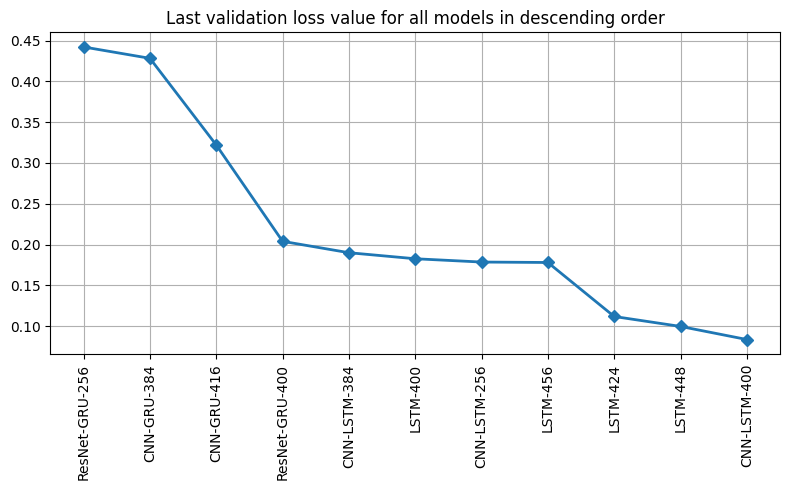

In [61]:
fig, ax = plt.subplots(figsize = (8,5), tight_layout = True)
df_lt = df2['last_val'].sort_values(ascending = False)
df_ltr = df2['last_train'].sort_values(ascending = False)
df_lt.plot(ax = ax, style='D-', linewidth = 2)
ax.grid()
ax.set_title('Last validation loss value for all models in descending order')
ax.tick_params(axis='x', labelrotation=90)
ax.set_xticks(range(len(df2.index)))
ax.set_xticklabels(df_lt.index)

plt.savefig('Last_train_test_loss_values.png')